In [1]:
import pandas as pd
import numpy as np
from numpy import trapz
import math
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
with open('inds_to_name.pkl','r') as pickleFile:
    inds_to_name = pickle.load(pickleFile)

In [3]:
cats = ['tee3','tee45','green0','green5','green10','green20','rough0','rough90',
        'rough375','fairway0','fairway300','fairway540','bunker','other']

In [4]:
ranks,reps = {},{}
for cat in cats:
    ranks[cat] = np.load('ranks-12-0.95-14/%s_ranks.npy' % cat)
    reps[cat] = np.load('ranks-12-0.95-14/%s_reps.npy' % cat)

In [5]:
# ranks = np.load('ranks-12-0.95-14/green0_ranks.npy')
# reps = np.load('ranks-12-0.95-14/green0_reps.npy')

In [6]:
# ranks.shape

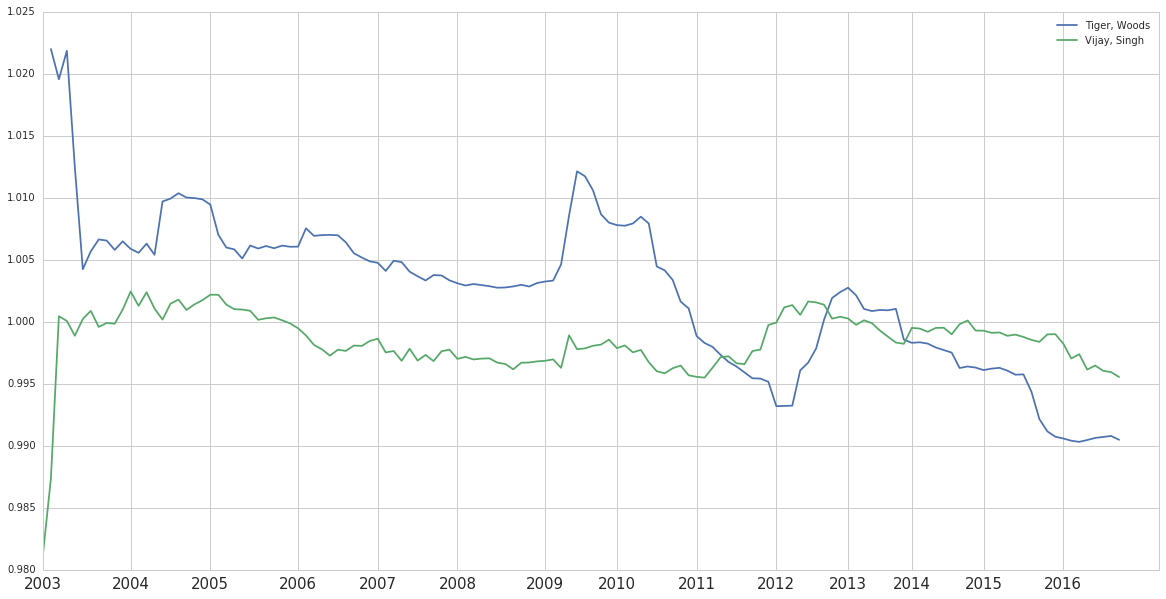

In [13]:
names_to_ind = {value:key for key,value in inds_to_name.iteritems()}
# inds_to_plot = [names_to_ind['Vijay, Singh'],names_to_ind['Tiger, Woods'],names_to_ind['Luke, Donald'],
#                 names_to_ind['Phil, Mickelson'],names_to_ind['Steve, Stricker'],names_to_ind['Jim, Furyk']]
inds_to_plot = [names_to_ind['Tiger, Woods'],names_to_ind['Vijay, Singh']]#,
                #names_to_ind['Dustin, Johnson'],names_to_ind['Steve, Stricker'],
                #names_to_ind['Jordan, Spieth'], names_to_ind['Jason, Day']]
fig, ax = plt.subplots(figsize=(20, 10))
for j in inds_to_plot:
    #area = trapz(y[np.logical_not(np.isnan(y))], dx=5)
    y = [ranks['green0'][j,i] for i in range(ranks['green0'].shape[1])]
    plt.plot(y,label = inds_to_name[j]);
ax.xaxis.set_ticks([i[1] for i in year_inds])
labels = [i[0] for i in year_inds]
ax.set_xticklabels(labels,fontsize=15);
plt.legend();

In [14]:
with open('hole_tups.pkl','r') as pickleFile:
    hole_tups = pickle.load(pickleFile)

In [15]:
bin_size = 4
window_size = 28
# n_tournament_groups = int(math.ceil(n_tournaments/float(bin_size)))
current_group = 0
tournament_groups = defaultdict(set)
tournaments = set()
group_to_tups = {}
holes_to_inflate = []
for tup in hole_tups:
    tournaments.add(tuple(tup[0:2]))
    tournament_group = (len(tournaments)-1)/bin_size
    if tournament_group>current_group:
        current_group = tournament_group
        group_to_tups[current_group] = holes_to_inflate
        holes_to_inflate = []
    tournament_groups[current_group+1].add(tuple(tup[0:2]))
    holes_to_inflate.append(tuple(tup))

In [12]:
year_inds = [max([[i[0] for i in tournament_groups[j]]]) for j in tournament_groups]
from collections import Counter
year_inds = [Counter(i) for i in year_inds]
year_inds = [sorted(i,key=year_inds[u].get,reverse=True)[0] for u,i in enumerate(year_inds)]
year_inds = np.array(year_inds)
year_inds = [(year,np.argwhere(year_inds==year).min()) for year in range(2003,2017)]

In [16]:
with open('num_to_ind.pkl','r') as pickleFile:
    num_to_ind = pickle.load(pickleFile)

In [17]:
data = pd.read_csv('data/round.csv')
data.insert(5,'Player_Index',[num_to_ind[num] if num in num_to_ind else np.nan for num in data.Player_Number])
rounds = data.groupby(['Tournament_Year','Permanent_Tournament_#','Round_Number','Course_#'])
n_players = len(num_to_ind)

In [18]:
d = {'Player_Index':[],'Permanent_Tournament_#':[],'Course_#':[],'Finishing_Pct':[]}
d.update({'Field_Strength_%s' % cat:[] for cat in cats})
d.update({'Rating_%s' % cat:[] for cat in cats})
d.update({'Reps_%s' % cat:[] for cat in cats})
d.update({'Pct_Reps_%s' % cat:[] for cat in cats})
master_df = pd.DataFrame(d)
for j in range(ranks['green0'].shape[1]):
    d = {'rank_%s' % cat: ranks[cat][:,j] for cat in cats}
    d.update({'reps_%s' % cat: reps[cat][:,j] for cat in cats})
    df = pd.DataFrame(d).dropna()
    pct_reps,rank_dict,reps_dict,pct_reps_dict = {},{},{},{}
    for cat in cats:
        pct_reps[cat] = pd.Series(df['reps_%s' % cat][df['reps_%s' % cat]!=0]).rank(pct=True)
        df.insert(len(df.columns),'pct_reps_%s' % cat,[0]*len(df))
        df.ix[df['reps_%s' % cat]!=0,'pct_reps_%s' % cat] = pct_reps[cat]
        rank_dict[cat] = df['rank_%s' % cat].to_dict()
        reps_dict[cat] = df['reps_%s' % cat].to_dict()
        pct_reps_dict[cat] = df['pct_reps_%s' % cat].to_dict()
    years = [i[0] for i in tournament_groups[j+1]]
    t_ids = [i[1] for i in tournament_groups[j+1]]
    df2 = data[data['Tournament_Year'].isin(years) & data['Permanent_Tournament_#'].isin(t_ids)]
    grouped = df2.groupby(['Player_Index','Permanent_Tournament_#','Course_#','Tournament_Year'],as_index=False)
    df3 = grouped['Finishing_Pct'].mean()
    for cat in cats:
        df3['Rating_%s' % cat] = df3['Player_Index'].map(rank_dict[cat])
        df3['Reps_%s' % cat] = df3['Player_Index'].map(reps_dict[cat])
        df3['Pct_Reps_%s' % cat] = df3['Player_Index'].map(pct_reps_dict[cat])
    df3 = df3[np.array([df3['Rating_%s' % cat]!=0 for cat in cats]).T.sum(1)==14].dropna()
    tourn_strength_dict = {}
    for cat in cats:
        tourn_strength_dict[cat] = df3.groupby('Permanent_Tournament_#')['Rating_%s' % cat].mean().to_dict()
        df3['Field_Strength_%s' % cat] = df3['Permanent_Tournament_#'].map(tourn_strength_dict[cat])
    master_df = pd.concat([master_df,df3])

In [19]:
master_df.shape

(81839, 61)

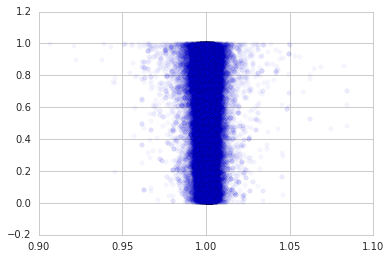

In [22]:
plt.scatter(master_df['Rating_%s' % ('green0',)],master_df.Finishing_Pct,alpha=.04);
plt.xlim(.9,1.1);

In [23]:
np.corrcoef(master_df['Rating_%s' % ('green0',)],master_df.Finishing_Pct)

array([[ 1.        , -0.05573524],
       [-0.05573524,  1.        ]])

In [24]:
np.corrcoef(master_df['Rating_%s' % ('green0',)]-master_df['Field_Strength_%s' % ('green0',)],master_df.Finishing_Pct)

array([[ 1.        , -0.05329063],
       [-0.05329063,  1.        ]])

In [25]:
for cat in cats:
    print cat,np.corrcoef(master_df['Rating_%s' % cat],master_df.Finishing_Pct)[0,1]

tee3 -0.210403217179
tee45 -0.19095332469
green0 -0.0557352416899
green5 -0.0373133974574
green10 -0.0467950825195
green20 -0.0828254843438
rough0 -0.0306417448328
rough90 -0.0297940606742
rough375 -0.118710092767
fairway0 -0.101011799588
fairway300 -0.192025976672
fairway540 -0.171552244305
bunker -0.046564842089
other -0.00278897426562


In [26]:
from sklearn.feature_selection import f_regression

In [74]:
#X_lab = np.array(cats)[np.argsort([np.corrcoef(master_df['Rating_%s' % cat],master_df.Finishing_Pct)[0,1] for cat in cats])]
X = master_df[['Rating_%s' % (cat,) for cat in cats]].values - master_df[['Field_Strength_%s' % (cat,) for cat in cats]].values

In [30]:
X_lab

array(['tee3', 'fairway300', 'tee45', 'fairway540', 'rough375', 'fairway0',
       'green20', 'green0', 'green10', 'bunker', 'green5', 'rough0',
       'rough90', 'other'], 
      dtype='|S10')

In [75]:
y = master_df.Finishing_Pct

In [50]:
F,pval = f_regression(X,y)

In [51]:
F

array([  3.79069649e+03,   3.09696167e+03,   2.55012035e+02,
         1.14099666e+02,   1.79598286e+02,   5.65284688e+02,
         7.69103241e+01,   7.27101071e+01,   1.16973810e+03,
         8.43622108e+02,   3.13318867e+03,   2.48150824e+03,
         1.77831489e+02,   6.36564027e-01])

In [52]:
pval

array([  0.00000000e+000,   0.00000000e+000,   2.56203972e-057,
         1.29033116e-026,   6.55144640e-041,   1.57952713e-124,
         1.82244586e-018,   1.52673859e-017,   1.45681358e-254,
         1.54219839e-184,   0.00000000e+000,   0.00000000e+000,
         1.58955253e-040,   4.24960073e-001])

In [54]:
np.argsort(pval)

array([ 0,  1, 10, 11,  8,  9,  5,  2,  4, 12,  3,  6,  7, 13])

In [55]:
np.argsort([np.corrcoef(master_df['Rating_%s' % cat],master_df.Finishing_Pct)[0,1] for cat in cats])

array([ 0, 10,  1, 11,  8,  9,  5,  2,  4, 12,  3,  6,  7, 13])

In [56]:
np.array(cats)[np.argsort(pval)]

array(['tee3', 'tee45', 'fairway300', 'fairway540', 'rough375', 'fairway0',
       'green20', 'green0', 'green10', 'bunker', 'green5', 'rough0',
       'rough90', 'other'], 
      dtype='|S10')

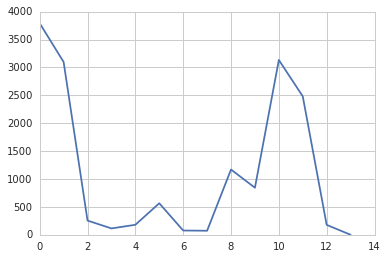

In [53]:
plt.plot(F)

In [44]:
import statsmodels.api as sm

In [76]:
X = sm.add_constant(X[:,:-1])
model = sm.OLS(y, X)
results = model.fit()

In [77]:
print results.summary()

                            OLS Regression Results                            
Dep. Variable:          Finishing_Pct   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     719.8
Date:                Sat, 17 Sep 2016   Prob (F-statistic):               0.00
Time:                        18:15:30   Log-Likelihood:                -11638.
No. Observations:               81839   AIC:                         2.330e+04
Df Residuals:                   81825   BIC:                         2.343e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.5570      0.001    571.155      0.0

In [78]:
y = results.resid**2
X = master_df[['Reps_%s' % (cat,) for cat in cats]].values

In [79]:
X = sm.add_constant(X[:,:-1])
model = sm.OLS(y, X)
results = model.fit()

In [80]:
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     32.14
Date:                Sat, 17 Sep 2016   Prob (F-statistic):           6.39e-81
Time:                        18:15:39   Log-Likelihood:                 95361.
No. Observations:               81839   AIC:                        -1.907e+05
Df Residuals:                   81825   BIC:                        -1.906e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0689      0.001    111.797      0.0

In [81]:
w = 1/results.predict(X)

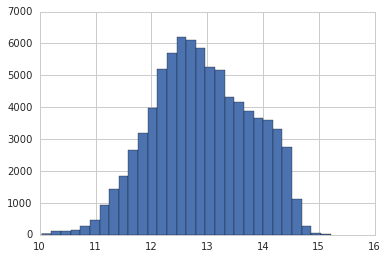

In [84]:
plt.hist(w,bins=30);

In [86]:
X = master_df[['Rating_%s' % (cat,) for cat in cats]].values - master_df[['Field_Strength_%s' % (cat,) for cat in cats]].values
X = sm.add_constant(X[:,:-1])
y = master_df.Finishing_Pct
model = sm.WLS(y, X, w)
results = model.fit()

In [87]:
print results.summary()

                            WLS Regression Results                            
Dep. Variable:          Finishing_Pct   R-squared:                       0.105
Model:                            WLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     736.0
Date:                Sat, 17 Sep 2016   Prob (F-statistic):               0.00
Time:                        18:18:51   Log-Likelihood:                -11538.
No. Observations:               81839   AIC:                         2.310e+04
Df Residuals:                   81825   BIC:                         2.323e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.5577      0.001    573.051      0.0

In [88]:
cats

['tee3',
 'tee45',
 'green0',
 'green5',
 'green10',
 'green20',
 'rough0',
 'rough90',
 'rough375',
 'fairway0',
 'fairway300',
 'fairway540',
 'bunker',
 'other']